In [2]:
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import glob
import numpy
import random

from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchsummary import summary

In [3]:
from torchvision.transforms.transforms import RandomPerspective
import torchvision
import torchvision.transforms as transforms

image_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),

        # Added transformation------------------------------------------

        transforms.GaussianBlur(kernel_size=(5, 13), sigma=(0.1, 0.2)),
        #---------------------------------------------------------------
        
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [4]:
dataset = 'C:/KPT/Dataset/fruit_dataset_modi-20220724T221022Z-001/fruit_dataset_modi'

train_directory = os.path.join(dataset, 'train')
test_directory = os.path.join(dataset, 'validation')

batchSize = 32

num_classes = len(os.listdir(train_directory))
print(num_classes)

data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),

    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])
}

4


In [5]:
train_data_size = len(data['train'])
test_data_size = len(data['test'])

train_data_loader = DataLoader(data['train'], batch_size=batchSize, shuffle=True)
test_data_loader = DataLoader(data['test'], batch_size=batchSize, shuffle=True)

In [6]:
from torch.utils.data import DataLoader
trainloader = DataLoader(dataset=data['train'], # use custom created train Dataset
                                     batch_size=4, # how many samples per batch?
                                     num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

testloader = DataLoader(dataset=data['test'], # use custom created test Dataset
                                    batch_size=4, 
                                    num_workers=0, 
                                    shuffle=False) # don't usually need to shuffle testing data

train_data_size = len(trainloader.dataset)
test_data_size = len(testloader.dataset)

print(train_data_size)
print(test_data_size)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

486
191


In [7]:
import time # to calculate training time

def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))

        model.train()

        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(trainloader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            train_acc += acc.item() * inputs.size(0)

        with torch.no_grad():

            model.eval()

            for j, (inputs, labels) in enumerate(testloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = loss_criterion(outputs, labels)
                valid_loss += loss.item() * inputs.size(0)
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))
                acc = torch.mean(correct_counts.type(torch.FloatTensor))
                valid_acc += acc.item() * inputs.size(0)

        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size
        avg_test_loss = valid_loss/test_data_size 
        avg_test_acc = valid_acc/test_data_size

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start))
        
        torch.save(model, 'Fruit_model_'+str(epoch)+'.pt')
            
    return model, history

In [8]:
model_ft = models.googlenet(pretrained=True)
num_ftrs = model_ft.fc.in_features

for module,param in zip(model_ft.modules(), model_ft.parameters()):
  if isinstance(module, nn.BatchNorm2d):
    param.requires_grad = False

# model_ft.fc = nn.Linear(num_ftrs, num_classes)
model_ft.fc = nn.Sequential(nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(64, num_classes))
 
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)

C:\Users\Amireen\anaconda3\envs\gpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\Amireen\anaconda3\envs\gpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
num_epochs = 40
trained_model, history = train_and_validate(model_ft, criterion, optimizer_ft, num_epochs)

Epoch: 1/40
Epoch : 000, Training: Loss: 1.2974, Accuracy: 40.5350%, 
		Validation : Loss : 1.0884, Accuracy: 85.3403%, Time: 51.8297s
Epoch: 2/40
Epoch : 001, Training: Loss: 0.9276, Accuracy: 65.0206%, 
		Validation : Loss : 0.5916, Accuracy: 68.0628%, Time: 28.1887s
Epoch: 3/40
Epoch : 002, Training: Loss: 0.6236, Accuracy: 74.2798%, 
		Validation : Loss : 0.2338, Accuracy: 96.8586%, Time: 23.4513s
Epoch: 4/40
Epoch : 003, Training: Loss: 0.4138, Accuracy: 86.4198%, 
		Validation : Loss : 0.0990, Accuracy: 97.3822%, Time: 26.2155s
Epoch: 5/40
Epoch : 004, Training: Loss: 0.2325, Accuracy: 93.2099%, 
		Validation : Loss : 0.0765, Accuracy: 97.9058%, Time: 27.9468s
Epoch: 6/40
Epoch : 005, Training: Loss: 0.2267, Accuracy: 92.5926%, 
		Validation : Loss : 0.1101, Accuracy: 96.3351%, Time: 24.6681s
Epoch: 7/40
Epoch : 006, Training: Loss: 0.2055, Accuracy: 93.8272%, 
		Validation : Loss : 0.0822, Accuracy: 97.3822%, Time: 23.4174s
Epoch: 8/40
Epoch : 007, Training: Loss: 0.2147, Accura

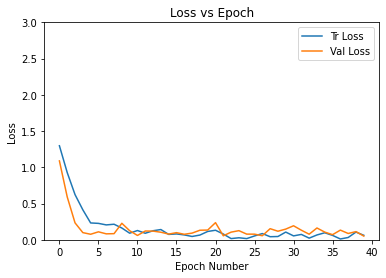

In [10]:
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.ylim(0,3)
plt.show()

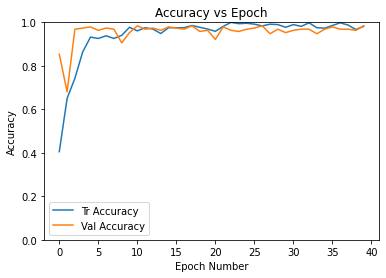

In [11]:
plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.ylim(0,1)
plt.show()

In [12]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
#         images, labels = data
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
#         images = images.view(images.size(0), -1)
        outputs = model_ft(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network: {100 * correct // total} %')

Accuracy of the network: 98 %


In [13]:
correct_pred = {classname: 0 for classname in os.listdir(train_directory)}
total_pred = {classname: 0 for classname in os.listdir(train_directory)}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
#         images = images.view(images.size(0), -1)
        outputs = model_ft(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[os.listdir(train_directory)[label]] += 1
            total_pred[os.listdir(train_directory)[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: Durian is 100.0 %
Accuracy for class: Pumpkin is 100.0 %
Accuracy for class: Tomato is 97.4 %
Accuracy for class: Watermelon is 96.9 %


<AxesSubplot:>

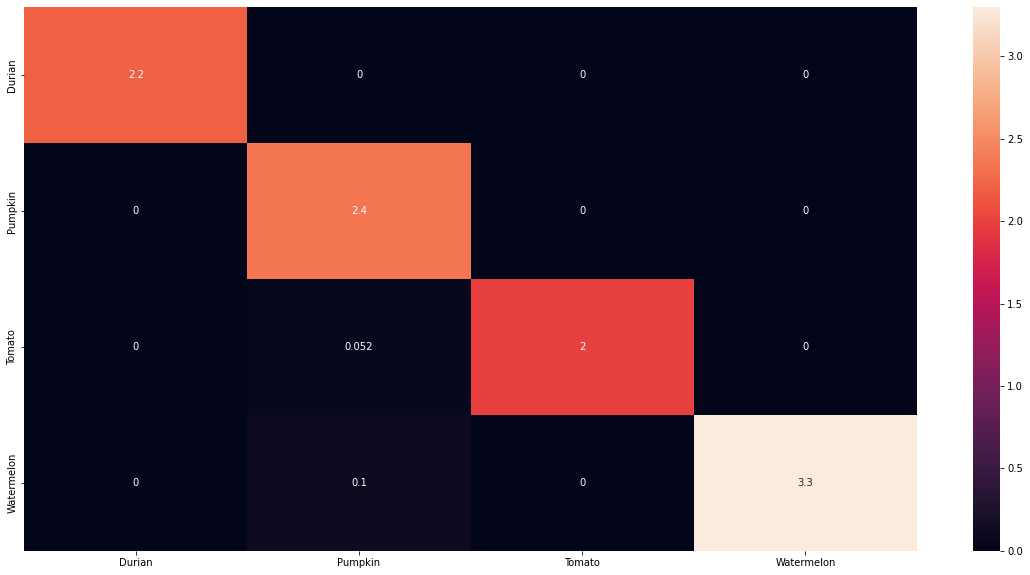

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

model_ft.to('cpu')

# iterate over test data
for inputs, labels in testloader:
#         #reshape images so they can be fed to a nn.Linear()
#         inputs = inputs.view(inputs.size(0), -1)
        output = model_ft(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('Durian', 'Pumpkin', 'Tomato', 'Watermelon')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (20,10))
sn.heatmap(df_cm, annot=True)

In [15]:
save_path = 'C:/KPT/Model_ft_Fruit_Classification.pt'
torch.save(model_ft.state_dict(), save_path)

In [16]:
save_path = 'C:/KPT/Model_ft_Fruit_Classification_.pt'
torch.save(model_ft, save_path)